In [52]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [53]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

In [55]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "data/"
stock_data_list = []

for filename in os.listdir(directory):
  file_path = os.path.join(directory, filename)
  stock_data = pd.read_csv(file_path)
  stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
  stock_data['Date'] = pd.to_datetime(stock_data.Date)
  stock_data_list.append(stock_data)
  print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [56]:
for i in range(len(stock_data_list)):
  stock_data_list[i] = stock_data_list[i].dropna()

In [57]:
def calculate_technical_indicators(data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14):
  # rsi_period - number of sessions considered when calculating RSI
  # so_period - number of sessions considered when calculating stochastic oscillator K
  # so_d_period - numbers of sessions considered when calculating moving average of the stochastic oscillator K
  # tema_period - number of sessions considered when calculating TEMA
  # cgi_period - number of sessions considered when calculating CGI
  # wpi_period - number of sessions considered when calculating Williams' Percent Range

  # Moving averages for periods of 10, 30 and 60 days
#   data['MovingAverage4'] = data['Close'].rolling(4).mean()
#   data['MovingAverage7'] = data['Close'].rolling(7).mean()
  data['MovingAverage20'] = data['Close'].rolling(20).mean()

  # Relative Strength Index RSI
  increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
  increase_difference[increase_difference < 0] = 0
  decrease_difference[decrease_difference > 0] = 0
  roll_increase = increase_difference.ewm(span = rsi_period).mean()
  roll_decrease = decrease_difference.abs().ewm(span = rsi_period).mean()
  RS = roll_increase / roll_decrease
#  data['RSI'] = 100 - (100 / (1 + RS))

  # Rate of Change ROC
#  data['ROC'] = data['Close'].pct_change()

  # Stochastic Oscillator K
  L14, H14 = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
#  data['K'] = (data['Close'] - L14)/(H14 - L14)

  # Moving average of the Stochastic Oscillator D
#   data['D'] = data['K'].rolling(so_d_period).mean()

  # Moving Average Convergence / Divergence MACD
  EMA_26 = data['Close'].ewm(26).mean()
  EMA_12 = data['Close'].ewm(12).mean()
#   data['MACD'] = EMA_12 - EMA_26

  # MACD Signal Line
#   data['MACD_Signal'] = data['MACD'].ewm(9).mean()

  # MACD histogram
#   data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

  # Percentage Price Oscillator PPO
#  data['PPO'] =(EMA_12 - EMA_26)/EMA_26

  # Triple Exponential Moving Average TEMA
  SEMA = data['Close'].ewm(tema_period).mean()
  DEMA = SEMA.ewm(tema_period).mean()
#   data['TEMA'] = DEMA.ewm(tema_period).mean()

  # Commodity Channel Index CGI
  typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
  MA = typical_price.rolling(cgi_period).mean()
  mean_deviation = (MA - typical_price).abs().rolling(cgi_period).mean()
#  data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)

  # Williams' Percent Range
#  data['Percent_Range'] = (data['Highest'].rolling(wpi_period).max() - data['Close']) / (data['Highest'].rolling(wpi_period).max() - data['Lowest'].rolling(wpi_period).min())

  return data

In [58]:
def scale_data(data):
  list_of_features = []
  for column in data.columns:
    list_of_features.append(data[column])

  dataset = np.transpose(list_of_features)

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)

  return scaled_data, scaler


In [75]:
def prepare_input_and_output(data, number_of_sessions=60):
  # number_of_sessions - number of considered previous sessions as an input
  X = []
  Y = []
  for i in range(number_of_sessions, data.shape[0]):
    X.append(data[i-number_of_sessions:i, :])
    Y.append(data[i, :])
  return X, Y

**Lerning based on prices and volume only**

In [60]:
scaled_stocks_basic = []
scalers_basic = []

for i in range(len(stock_data_list)):
  # Date is dropped as it isn't considered for learning
  scaled_stock, scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  scaled_stocks_basic.append(scaled_stock)
  scalers_basic.append(scaler)

In [82]:
X_all_basic = []
Y_all_basic = []
scaled_X_list_basic = []
scaled_Y_list_basic = []

for stock in scaled_stocks_basic:
  X, Y = prepare_input_and_output(stock, 60)
  scaled_X_list_basic.append(np.array(X))
  scaled_Y_list_basic.append(np.array(Y))
  X_all_basic = X_all_basic + X
  Y_all_basic = Y_all_basic + Y

X_all_basic, Y_all_basic = np.array(X_all_basic), np.array(Y_all_basic)
print('Shape of input matrix: ' + str(X_all_basic.shape))
print('Shape of output matrix: ' + str(Y_all_basic.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [83]:
from sklearn.model_selection import train_test_split

X_train_basic, X_valid_basic, Y_train_basic, Y_valid_basic = train_test_split(X_all_basic, Y_all_basic, test_size=0.05)

print('Shape of training input matrix: ' + str(X_train_basic.shape))
print('Shape of training output matrix: ' + str(Y_train_basic.shape))
print('Shape of validation input matrix: ' + str(X_valid_basic.shape))
print('Shape of validation output matrix: ' + str(Y_valid_basic.shape))

Shape of training input matrix: (72511, 60, 5)
Shape of training output matrix: (72511, 5)
Shape of validation input matrix: (3817, 60, 5)
Shape of validation output matrix: (3817, 5)


In [84]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4864      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 55        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2266/2266 [==============================] - 10s 4ms/step - loss: 0.0084 - val_loss: 6.5928e-04
Epoch 2/5
2266/2266 [==============================] - 9s 4ms/step - loss: 5.1035e-04 - val_loss: 5.5036e-04
Epoch 3/5
2266/2266 [==============================] - 8s 4ms/step - loss: 4.7402e-04 - val_loss: 5.5042e-04
Epoch 4/5
2266/2266 [==============================] - 9s

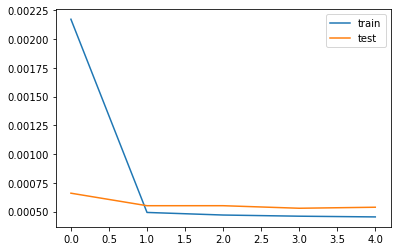

In [85]:
model = Sequential()
model.add(LSTM(32, input_shape=[X_train_basic.shape[1], X_train_basic.shape[2]]))#, return_sequences=True))
#model.add(LSTM(64))
model.add(Dense(10, activation='relu'))
model.add(Dense(X_train_basic.shape[2]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train_basic, Y_train_basic, epochs=5, validation_data=(X_valid_basic, Y_valid_basic))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [87]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions = model.predict(np.array(scaled_X_list_basic[0]))
predictions = scalers_basic[0].inverse_transform(predictions)

mae = np.mean(np.abs((predictions[:,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1])))
naive_forcast_difference = [abs(scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[i + 1,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[i,1]) for i in range(scaled_Y_list_basic[0].shape[0] - 1)]
naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
mape = np.mean((np.abs((predictions[:,1] - scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1]))/scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1])*100)
naive_forcast_mape = (naive_forcast_mae/scalers_basic[0].inverse_transform(scaled_Y_list_basic[0])[:,1].mean()) * 100

print('Prediction mean absolute error: ' + str(mae))
print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

print('Prediction mean absolute percentage error: ' + str(mape))
print('Naive forcast mean absolute percentage error: ' + str(naive_forcast_mape))

Prediction mean absolute error: 0.4738221535244943
Naive forcast mean absolute error: 0.46102780046156505
Prediction mean absolute percentage error: 1.46422192528474
Naive forcast mean absolute percentage error: 1.390148039713573


**Lerning based on prices, volume and technical indicators**

In [66]:
from IPython import display
# calculate_technical_indicators parameters -> data, rsi_period=10, so_period=14, so_d_period=4, tema_period=10, cgi_period=20, wpi_period=14
for i in range(len(stock_data_list)):
  stock_data_list[i] = calculate_technical_indicators(stock_data_list[i], rsi_period=60, so_period=5, so_d_period=3, tema_period=4, cgi_period=4, wpi_period=4)
  # moving averages return NaN when the considered period is greater than available data, these rows need to be dropped
  stock_data_list[i] = stock_data_list[i].dropna()

display.display(stock_data_list[0].head(100))

,Date,Open,Highest,Lowest,Close,Volume,MovingAverage20
19,1998-07-01,14.887,14.887,14.887,14.887,200541,12.91630
20,1998-07-02,15.160,15.160,15.160,15.160,170204,13.12075
21,1998-07-03,15.544,15.544,15.544,15.544,178954,13.28980
22,1998-07-06,16.086,16.086,16.086,16.086,204774,13.43135
23,1998-07-07,16.526,16.526,16.526,16.526,396111,13.58690
24,1998-07-08,16.358,16.358,16.358,16.358,123267,13.73680
25,1998-07-09,15.544,15.544,15.544,15.544,275231,13.87330
26,1998-07-10,15.544,15.544,15.544,15.544,119449,14.06160
27,1998-07-13,16.631,16.631,16.631,16.631,48999,14.33960
28,1998-07-14,17.885,17.885,17.885,17.885,244050,14.66110


In [67]:
scaled_stocks = []
scalers = []

for i in range(len(stock_data_list)):
  # Date is dropped as it isn't considered for learning
  scaled_stock, scaler = scale_data(stock_data_list[i].drop(columns='Date'))
  scaled_stocks.append(scaled_stock)
  scalers.append(scaler)

In [68]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
  X, Y = prepare_input_and_output(stock)
  scaled_X_list.append(np.array(X))
  scaled_Y_list.append(np.array(Y))
  X_all = X_all + X
  Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (75948, 60, 6)
Shape of output matrix: (75948, 6)


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.05)

print('Shape of training input matrix: ' + str(X_train.shape))
print('Shape of training output matrix: ' + str(Y_train.shape))
print('Shape of validation input matrix: ' + str(X_valid.shape))
print('Shape of validation output matrix: ' + str(Y_valid.shape))

Shape of training input matrix: (72150, 60, 6)
Shape of training output matrix: (72150, 6)
Shape of validation input matrix: (3798, 60, 6)
Shape of validation output matrix: (3798, 6)


In [70]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
Total params: 5,388
Trainable params: 5,388
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2255/2255 [==============================] - 11s 4ms/step - loss: 0.0309 - val_loss: 5.2532e-04
Epoch 2/10
2255/2255 [==============================] - 9s 4ms/step - loss: 5.5655e-04 - val_loss: 5.1199e-04
Epoch 3/10
2255/2255 [==============================] - 9s 4ms/step - loss: 5.2454e-04 - val_loss: 4.7526e-04
Epoch 4/10
2255/2255 [==============================] -

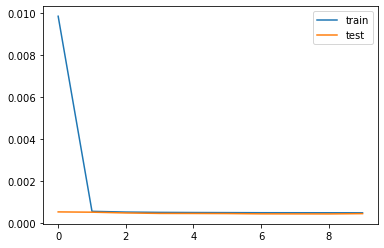

In [71]:
model = Sequential()
model.add(LSTM(32,input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
model.add(Dense(10, activation='relu'))
model.add(Dense(X_train.shape[2]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

predictions = model.predict(np.array(scaled_X_list[0]))
predictions = scalers[0].inverse_transform(predictions)

mae = np.mean(np.abs((predictions[:,1] - scalers[0].inverse_transform(scaled_Y_list[0])[:,1])))
naive_forcast_difference = [abs(scalers[0].inverse_transform(scaled_Y_list[0])[i + 1,1] - scalers[0].inverse_transform(scaled_Y_list[0])[i,1]) for i in range(scaled_Y_list[0].shape[0] - 1)]
naive_forcast_mae = sum(naive_forcast_difference) / len(naive_forcast_difference)
mape = np.mean((np.abs((predictions[:,1] - scalers[0].inverse_transform(scaled_Y_list[0])[:,1]))/scalers[0].inverse_transform(scaled_Y_list[0])[:,1])*100)
naive_forcast_mape = (naive_forcast_mae/scalers[0].inverse_transform(scaled_Y_list[0])[:,1].mean()) * 100

# print('Prediction mean absolute error: ' + str(mae))
# print('Naive forcast mean absolute error: ' + str(naive_forcast_mae))

print('Prediction mean absolute percentage error: ' + str(mape))
print('Naive forcast mean absolute percentage error: ' + str(naive_forcast_mape))

Prediction mean absolute percentage error: 1.2895425817330208
Naive forcast mean absolute percentage error: 1.3864937487529363


In [73]:
np.array(scaled_X_list[0]).shape

(5615, 60, 6)